<a href="https://colab.research.google.com/github/AliAramideh/Image_colorization/blob/main/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

---

In The Name Of God
<center>

# Author: **Ali Aramideh**

## Image Colorization using Autoencoder

1. Download the "landscape image colorization" dataset and slice it to `train_set`, `validation_set` and `test_set`.
2. Design and train an AutoEncoder using `PyTorch` (not `TensorFlow`) on the dataset to colorize grayscale images
3. plot learning curve and visualize grayscale images of test set, their corresponding color images and their colorized versions side by side.

### Import Necessary Libraries



we use kaggle enviornment for programming.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
import re
import matplotlib.pyplot as plt
import random
import os
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import torch.nn.functional as F
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F


from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torch.utils.data import Dataset
from skimage.color import rgb2lab, lab2rgb
from torchvision.transforms import transforms

### Load Dataset and Prepare It

In blew chunk you can see the contents of the dataset

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))

In [ ]:
# Set Paths
dataset = '/kaggle/input/landscape-image-colorization/landscape Images/'
num_images = len(os.listdir(dataset + 'color'))
num_images

7129

In [ ]:
## Set up Training and Test Indices

# 70% images are used for training
# 15% images are used for validation
# 15% images are use for testing

random_indices = random.sample(list(range(num_images)),num_images)

train_size = round(num_images*0.7)
train_set = random_indices[:train_size]

test_size = round(num_images*0.15)
test_set = random_indices[train_size:train_size + test_size]

validation_size = test_size
validation_set = random_indices[train_size + test_size:]

print('Train Size: ', train_size)
print('Test Size: ', test_size)
print('Validation Size: ', validation_size)

Train Size:  4990
Test Size:  1069
Validation Size:  1069


##### Encoder Dataset


The class receives training and test indices as input and creates datasets accordingly. The transformation of images is performed within the dataset class itself. The steps involved are as follows:

- Reading the image.
- Replicating the grayscale image channel three times to create a prototype RGB image. The additional dimensions will be discarded later. This step is done to convert the RGB image to the LAB color space.
- Dividing the RGB image by 255 to scale the values between 0 and 1.
- The output of rgb2lab() function provides L values in the range of 0-100, a values in the range of -128 (Green) to 127 (Red), and b values in the range of -128 (Blue) to 127 (Yellow). To normalize these values, tensor([0,128,128]) is added to each dimension, followed by division with tensor([100,255,255]).
- Extracting the L channel from the grayscale image to predict the a and b channels from the color image.

Note: Due to functional constraints, permute() function has been called multiple times. In future improvements, these calls will be reduced.

In [ ]:
class EncoderDataset(Dataset):
    def __init__(self, indices, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_indices = indices
        self.gray_path = img_dir+'gray/'
        self.color_path = img_dir+'color/'

    def __len__(self):
        return len(self.img_indices)

    def __getitem__(self, idx):
        img_name = str(idx)+'.jpg'
        image = read_image(self.gray_path+img_name)
        image = image.unsqueeze(0)
        image = F.interpolate(image,(160,160))
        image = image.squeeze(0)
        image = image.permute(1,2,0)
        image = image.repeat(1,1,3)
        image = image.permute(2,0,1)
        label = read_image(self.color_path+img_name)
        label = label.unsqueeze(0)
        label = F.interpolate(label,(160,160))
        label = label.squeeze(0)
        label = label.permute(1,2,0)
        label = label.permute(2,0,1)
        image = torch.tensor(rgb2lab(image.permute(1,2,0)/255))
        label = torch.tensor(rgb2lab(label.permute(1,2,0)/255))

        image = (image + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])
        label = (label + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])

        image = image.permute(2,0,1)
        label = label.permute(2,0,1)
        #Use L channel from image to predict a,b channels of label
        image = image[:1,:,:]
        label = label[1:,:,:]
        return image, label

In [ ]:
# Define transformations

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()]
)

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()]
)

In [ ]:
# Create Datasets

train_dataset = EncoderDataset(indices = train_set, img_dir = dataset)
test_dataset = EncoderDataset(indices = test_set, img_dir = dataset)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

### Define Your Model

- Network takes 1 channel input
- No maxpool layer is added at the encoder step
- Transpose Convolution takes place in decoder step
- Decoder outputs are concatenated with encoder output of the same layer
- Dropout layer added in decoder layer only
- Final layer CNN is the converging layer which outputs 2 channels

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 64, 3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, stride=2,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3,stride=2,padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3,stride=2,padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        self.t_conv1 = nn.ConvTranspose2d(256, 128, 3, stride=2,padding=1,output_padding=1)
        self.t_conv2 = nn.ConvTranspose2d(256, 64, 3, stride=2,padding=1,output_padding=1)
        self.t_conv3 = nn.ConvTranspose2d(128, 128, 3, stride=2,padding=1,output_padding=1)
        self.t_conv4 = nn.ConvTranspose2d(192, 15, 3, stride=1,padding=1)
        self.dropout = nn.Dropout(0.2)
        self.converge = nn.Conv2d(16,2,3,stride=1,padding=1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2))
        x4 = F.relu(self.conv4(x3))
        xd = F.relu(self.t_conv1(x4))
        xd = torch.cat((xd, x3), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv2(xd))
        xd = torch.cat((xd, x2), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv3(xd))
        xd = torch.cat((xd, x1), dim=1)
        xd = self.dropout(xd)
        xd = F.relu(self.t_conv4(xd))
        xd = torch.cat((xd, x), dim=1)
        x_out = F.relu(self.converge(xd))
        return x_out

### Fit The Model

In [ ]:
# To specify the device type responsible to load a tensor into memory
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the AutoEncoder model
model = AutoEncoder().to(device)

# Define loss function and optimizer
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
# Train the AutoEncoder model
num_epochs = 30
train_losses = []
test_losses = []
for epoch in range(1, num_epochs+1):
    train_loss = 0.0
    for data in tqdm(train_dataloader):
        images, labels = data
        images = images.float().to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_dataloader)
    train_losses.append(train_loss)
    print('Epoch: {} \nTrain Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

    test_loss = 0
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()*images.size(0)
    model.train()
    test_loss = test_loss/len(test_dataloader)
    print("Test Loss: {:.6f} ".format(test_loss))
    test_losses.append(test_loss)

100%|██████████| 312/312 [01:14<00:00,  4.21it/s]


Epoch: 1 
Train Loss: 0.042796
Test Loss: 0.162702 


100%|██████████| 312/312 [01:11<00:00,  4.36it/s]


Epoch: 2 
Train Loss: 0.040626
Test Loss: 0.141237 


100%|██████████| 312/312 [01:11<00:00,  4.38it/s]


Epoch: 3 
Train Loss: 0.039577
Test Loss: 0.135347 


100%|██████████| 312/312 [01:10<00:00,  4.41it/s]


Epoch: 4 
Train Loss: 0.038705
Test Loss: 0.142965 


100%|██████████| 312/312 [01:09<00:00,  4.48it/s]


Epoch: 5 
Train Loss: 0.038011
Test Loss: 0.135066 


100%|██████████| 312/312 [01:17<00:00,  4.04it/s]


Epoch: 6 
Train Loss: 0.037252
Test Loss: 0.150233 


100%|██████████| 312/312 [01:09<00:00,  4.46it/s]


Epoch: 7 
Train Loss: 0.036707
Test Loss: 0.136170 


100%|██████████| 312/312 [01:09<00:00,  4.46it/s]


Epoch: 8 
Train Loss: 0.036513
Test Loss: 0.132461 


100%|██████████| 312/312 [01:10<00:00,  4.41it/s]


Epoch: 9 
Train Loss: 0.036752
Test Loss: 0.133277 


100%|██████████| 312/312 [01:09<00:00,  4.47it/s]


Epoch: 10 
Train Loss: 0.035547
Test Loss: 0.127442 


100%|██████████| 312/312 [01:16<00:00,  4.06it/s]


Epoch: 11 
Train Loss: 0.035354
Test Loss: 0.128781 


100%|██████████| 312/312 [01:12<00:00,  4.30it/s]


Epoch: 12 
Train Loss: 0.035127
Test Loss: 0.125403 


100%|██████████| 312/312 [01:10<00:00,  4.42it/s]


Epoch: 13 
Train Loss: 0.035006
Test Loss: 0.126426 


100%|██████████| 312/312 [01:11<00:00,  4.36it/s]


Epoch: 14 
Train Loss: 0.034511
Test Loss: 0.123386 


100%|██████████| 312/312 [01:10<00:00,  4.44it/s]


Epoch: 15 
Train Loss: 0.034386
Test Loss: 0.131981 


100%|██████████| 312/312 [01:10<00:00,  4.44it/s]


Epoch: 16 
Train Loss: 0.034467
Test Loss: 0.123976 


100%|██████████| 312/312 [01:10<00:00,  4.40it/s]


Epoch: 17 
Train Loss: 0.033851
Test Loss: 0.118561 


100%|██████████| 312/312 [01:09<00:00,  4.48it/s]


Epoch: 18 
Train Loss: 0.033523
Test Loss: 0.118533 


100%|██████████| 312/312 [01:32<00:00,  3.36it/s]


Epoch: 19 
Train Loss: 0.033482
Test Loss: 0.125772 


100%|██████████| 312/312 [01:24<00:00,  3.71it/s]


Epoch: 20 
Train Loss: 0.033220
Test Loss: 0.132844 


100%|██████████| 312/312 [01:10<00:00,  4.43it/s]


Epoch: 21 
Train Loss: 0.033104
Test Loss: 0.121303 


100%|██████████| 312/312 [01:10<00:00,  4.45it/s]


Epoch: 22 
Train Loss: 0.032651
Test Loss: 0.135032 


100%|██████████| 312/312 [01:10<00:00,  4.45it/s]


Epoch: 23 
Train Loss: 0.032920
Test Loss: 0.122761 


100%|██████████| 312/312 [01:10<00:00,  4.43it/s]


Epoch: 24 
Train Loss: 0.032596
Test Loss: 0.120428 


100%|██████████| 312/312 [01:11<00:00,  4.37it/s]


Epoch: 25 
Train Loss: 0.031762
Test Loss: 0.119548 


100%|██████████| 312/312 [01:10<00:00,  4.42it/s]


Epoch: 26 
Train Loss: 0.031519
Test Loss: 0.116824 


100%|██████████| 312/312 [01:10<00:00,  4.45it/s]


Epoch: 27 
Train Loss: 0.031252
Test Loss: 0.121931 


100%|██████████| 312/312 [01:35<00:00,  3.27it/s]


Epoch: 28 
Train Loss: 0.031016
Test Loss: 0.125236 


100%|██████████| 312/312 [01:40<00:00,  3.12it/s]


Epoch: 29 
Train Loss: 0.030492
Test Loss: 0.117830 


100%|██████████| 312/312 [01:10<00:00,  4.40it/s]


Epoch: 30 
Train Loss: 0.030352
Test Loss: 0.111710 


In the training loop, we iterate over the train_loader, perform the forward pass, calculate the loss, perform the backward pass, and update the model's parameters. We also calculate the running loss for each epoch

### Plot The Results

While the model is trained as per expectation and producing colors which are not way-off, this model can be set for a base line model.

We cac define the functions to plot the learning curve and visualize the images. The plot_learning_curve function takes a list of loss values and plots the learning curve using Matplotlib

In [ ]:
def plot_learning_curve(loss_history, color, label):
    plt.plot(loss_history, color= color)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(label+' Learning Curve')
    plt.show()

In [ ]:
def plot_learning_both(loss_history1, loss_history2, color1, color2, label1,
                      label2):
    plt.plot(loss_history1, label= label1, color= color1)
    plt.plot(loss_history2, label= label2, color= color2)
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

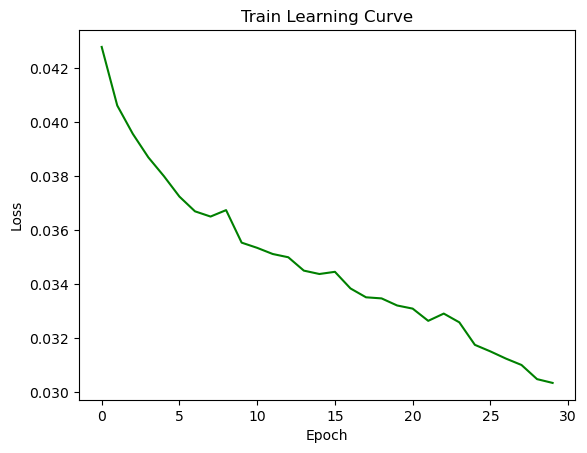

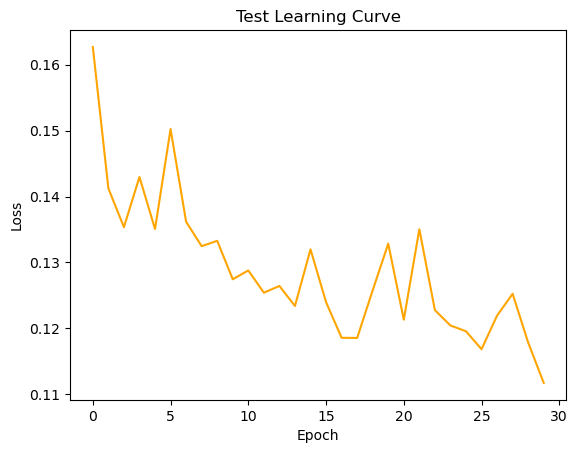

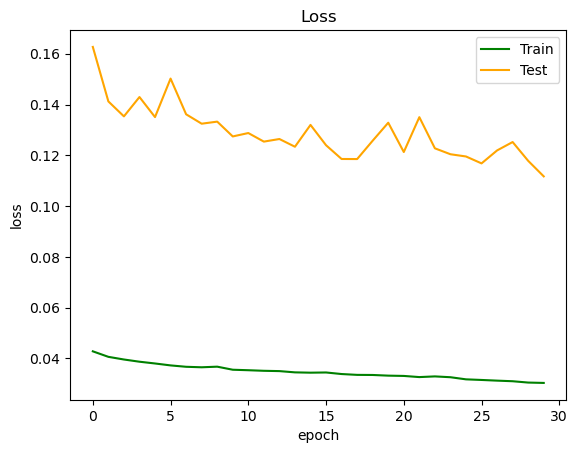

In [ ]:
plot_learning_curve(train_losses, 'green', 'Train')
plot_learning_curve(test_losses, 'orange', 'Test')
plot_learning_both(train_losses, test_losses, 'green', 'orange',
                   'Train', 'Test')

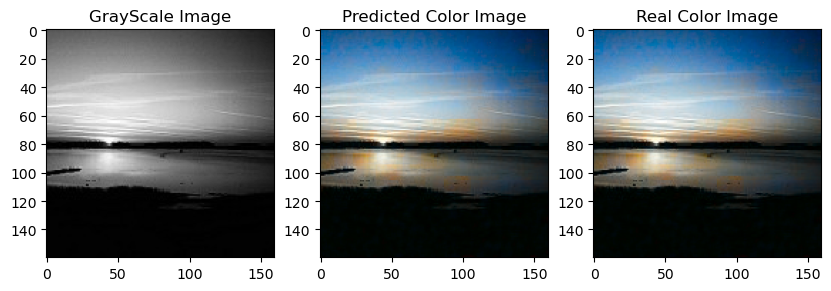

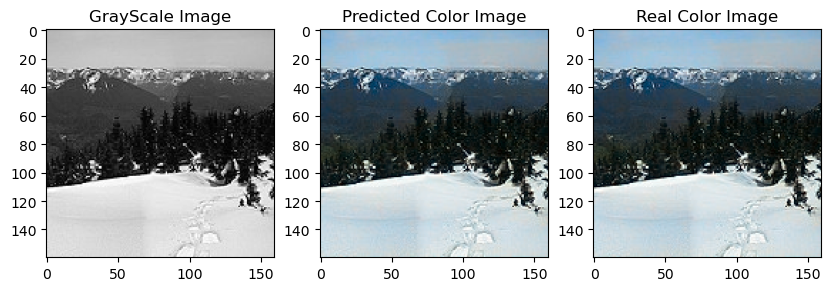

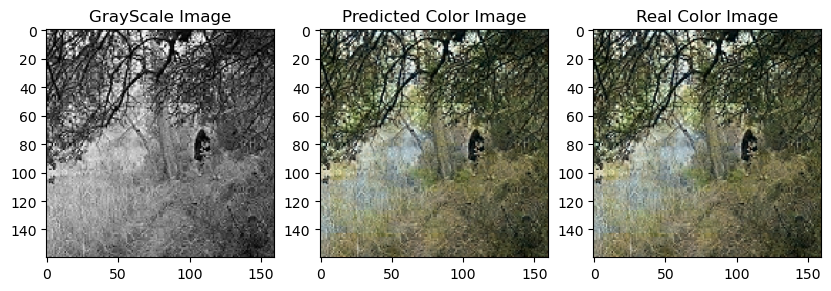

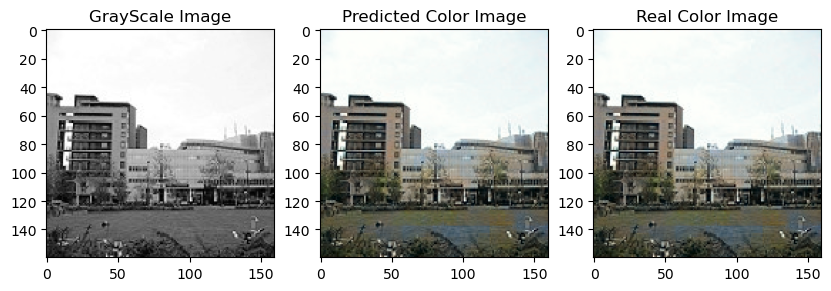

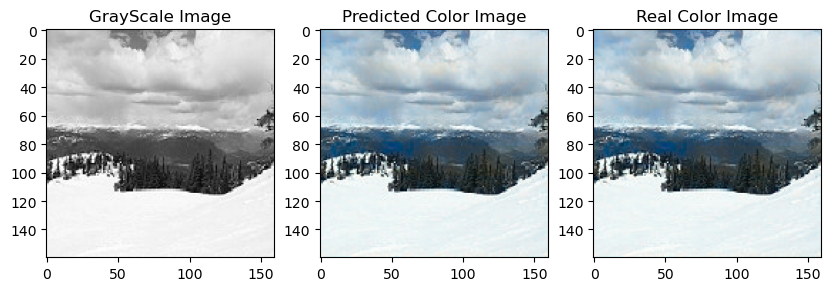

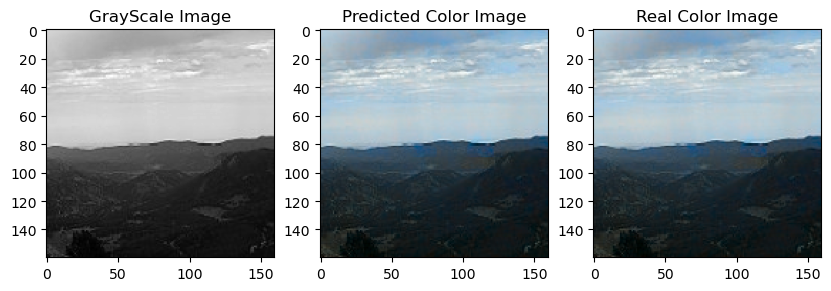

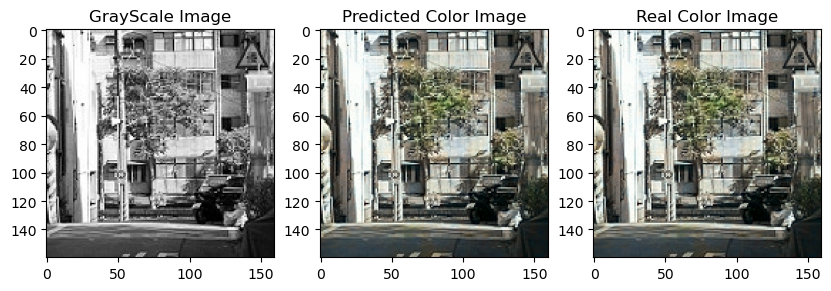

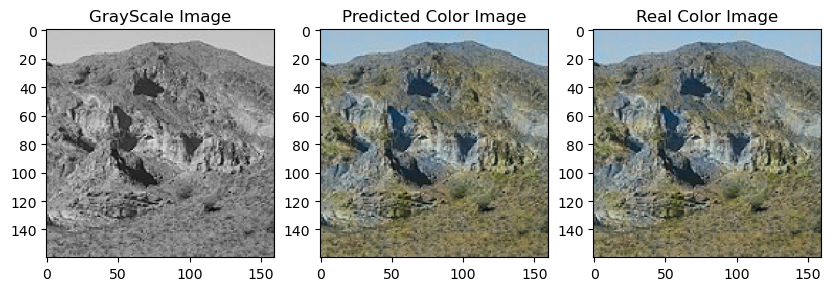

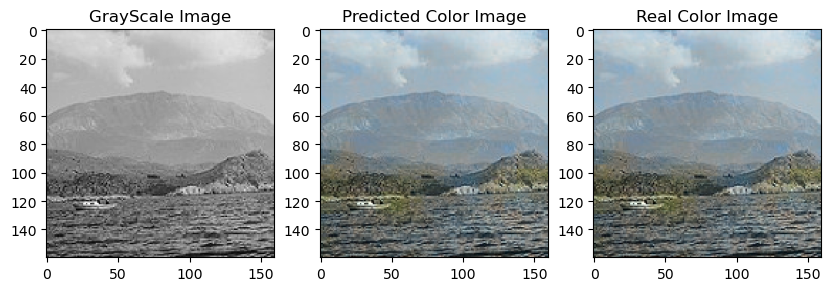

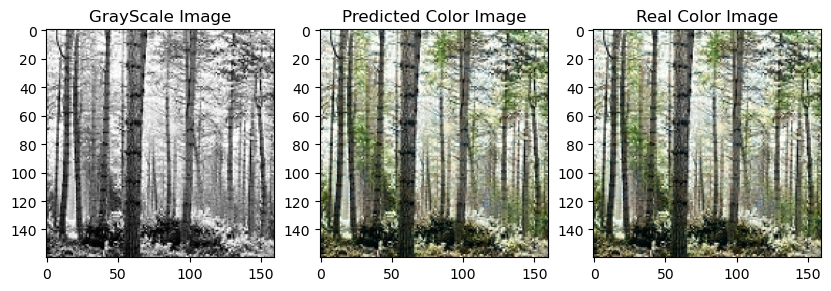

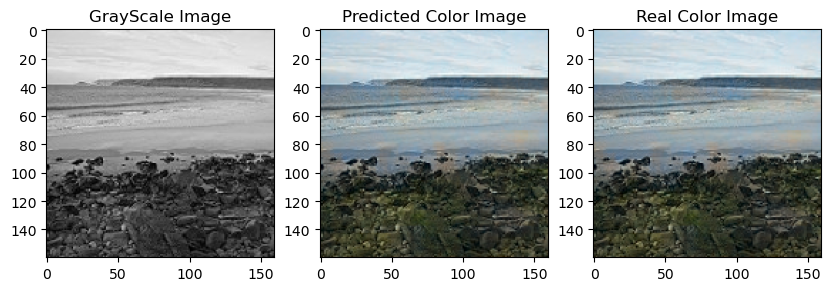

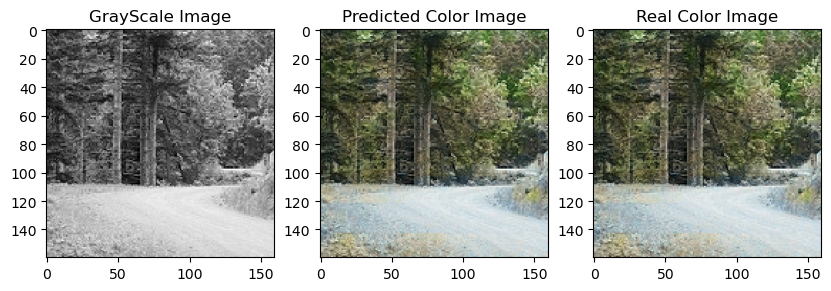

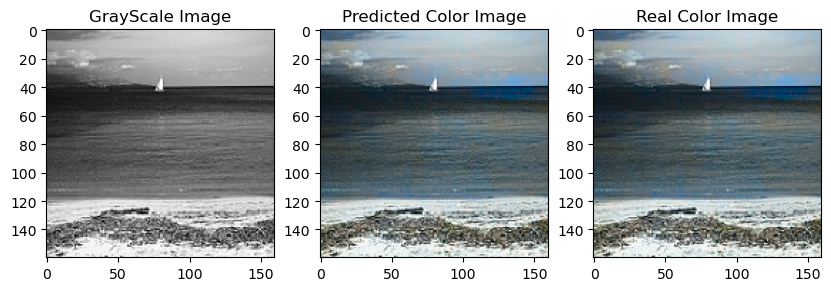

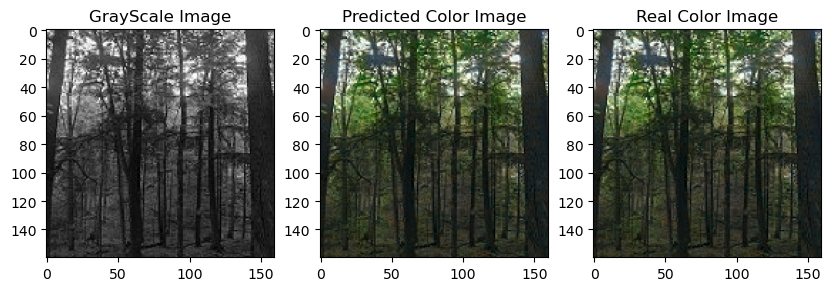

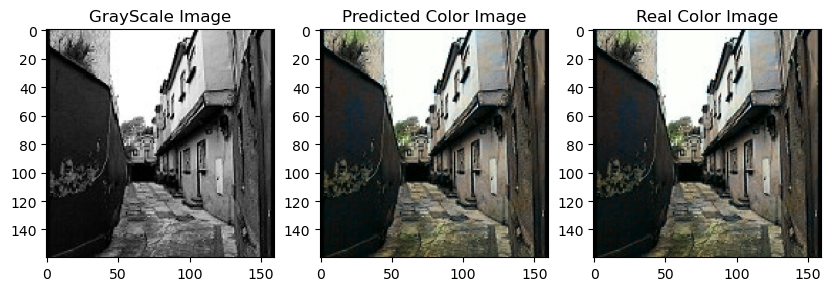

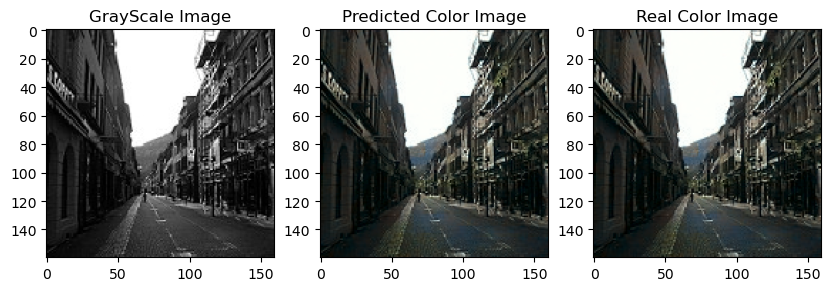

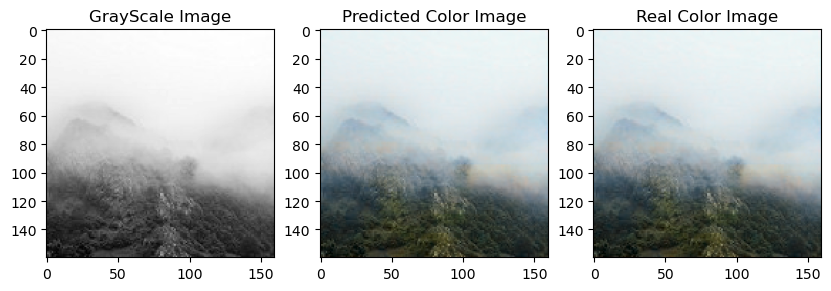

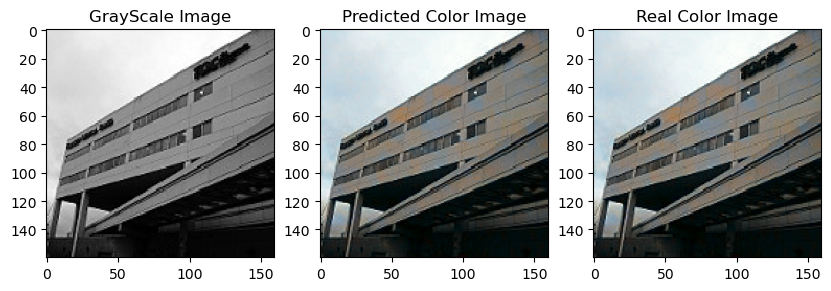

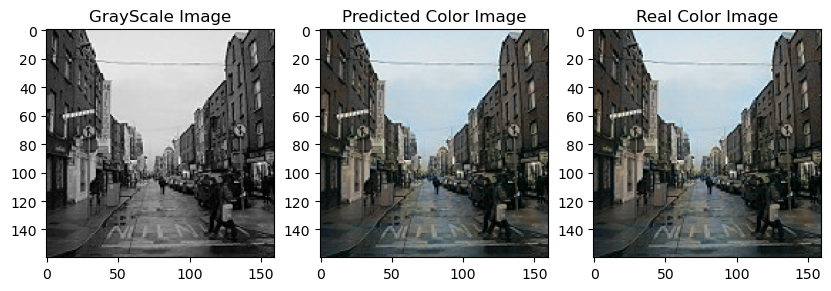

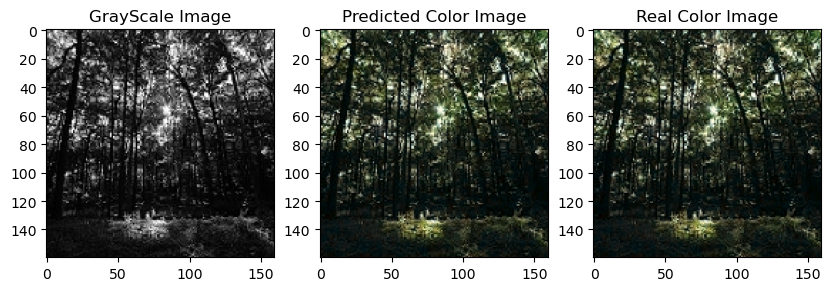

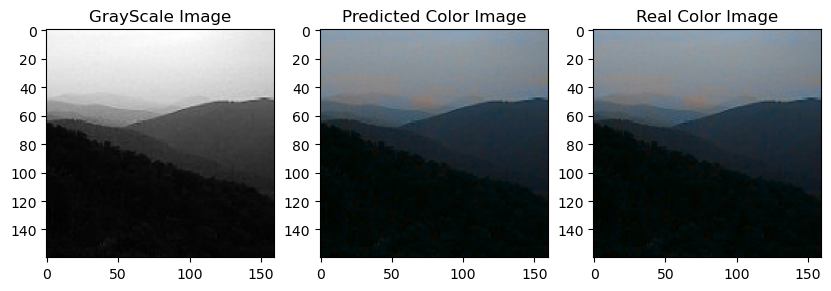

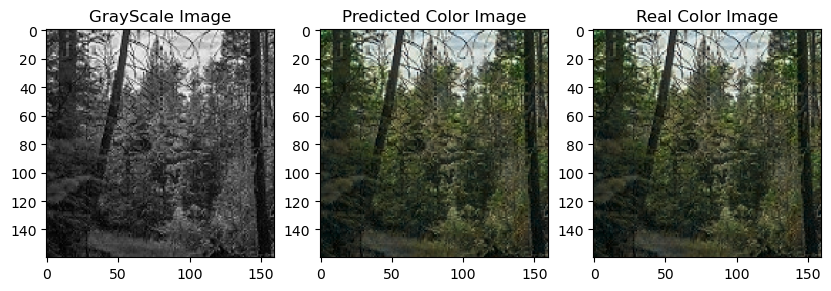

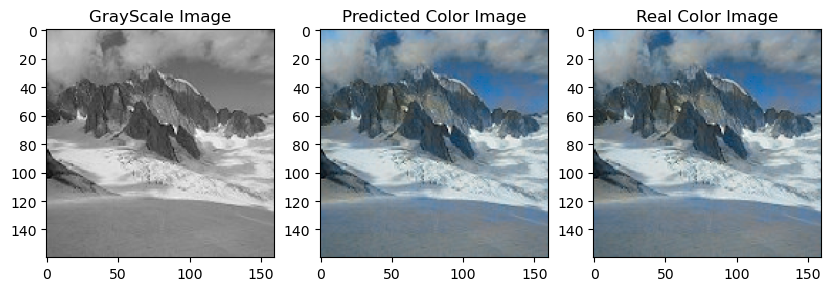

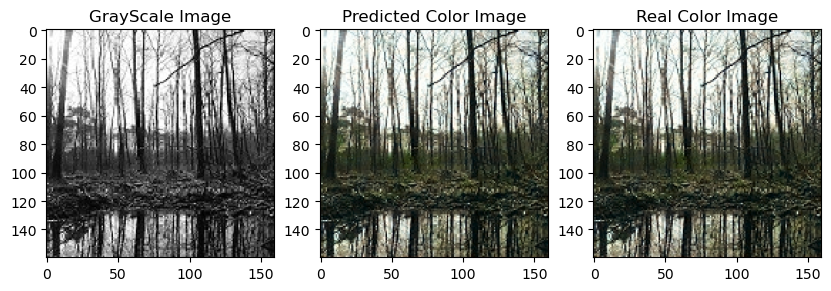

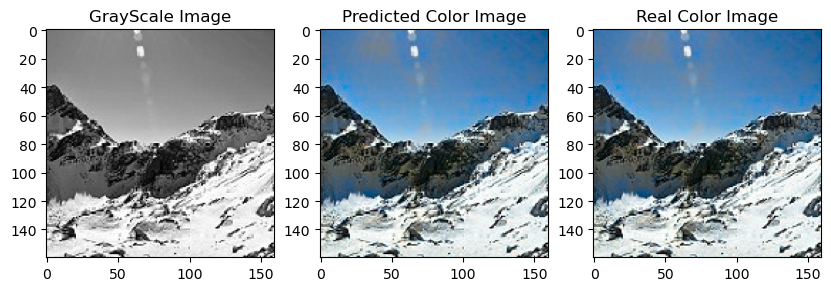

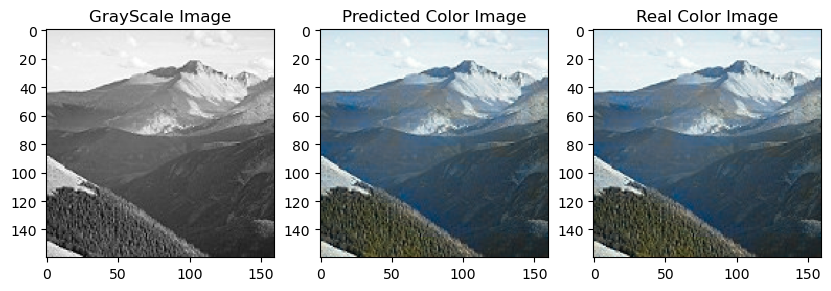

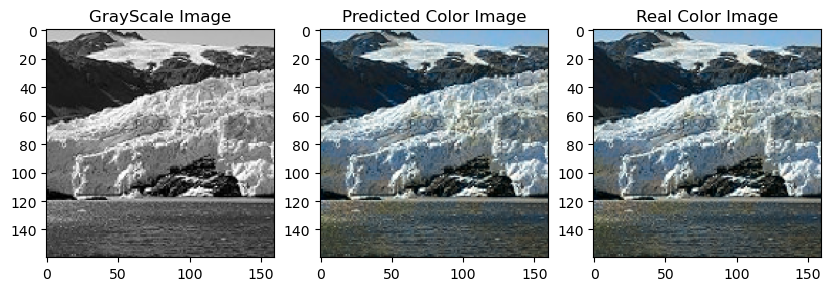

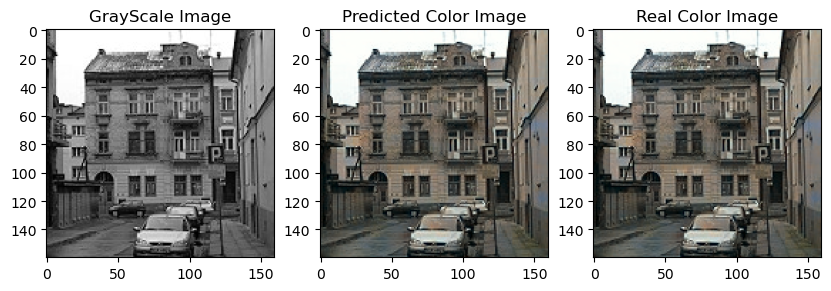

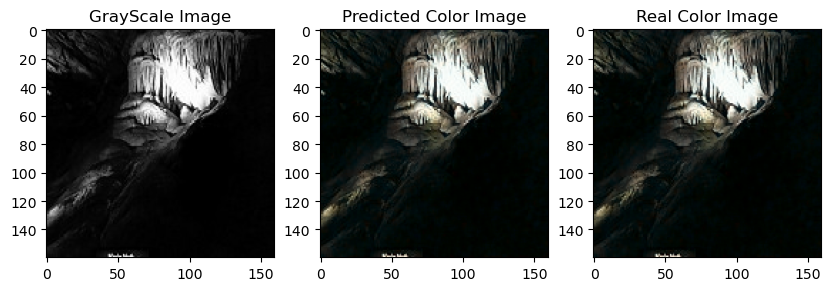

In [ ]:
##Test Data
# 30 data of test
for i in range(1, 30):
    test_img,test_label = next(iter(test_dataloader))
    pred = model.forward(test_img[0].float().cuda().view(1,1,160,160))
    lab_pred = torch.cat((test_img[0].view(1,160,160),pred[0].cpu()),dim=0)
    lab_pred_inv_scaled = lab_pred.permute(1,2,0) * torch.tensor([100,255,255]) - torch.tensor([0,128,128])
    rgb_pred = lab2rgb(lab_pred_inv_scaled.detach().numpy())
    fig = plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(test_img[0].permute(1,2,0),cmap='gray')
    plt.title('GrayScale Image')
    plt.subplot(132)
    plt.imshow(rgb_pred)
    plt.title('Predicted Color Image')
    plt.subplot(133)
    plt.imshow(rgb_pred)
    plt.title('Real Color Image')
    plt.show()